# [Bio Reps] Tune Hyper Params

In [2]:
# ============================================
# LOOCV comparison: ElasticNet vs TinyMLP (GPU-aware)
# ============================================
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import truncnorm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import ElasticNetCV

from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import BaseEstimator, TransformerMixin



# ---- Neural net (skorch / PyTorch)
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit
from skorch.callbacks import LRScheduler, GradientNormClipping,  EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from sklearn.model_selection import GroupShuffleSplit

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

import random
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# ============ Load your data ============
df = pd.read_excel(f'data/proteomics_data.xlsx', sheet_name='Sheet1')

# Features (assuming columns 5  1861 are omics features)
X = df.iloc[:, 5:1862].to_numpy(dtype=np.float32)
# Targets (both GR_mean and GR_sd)
y = df[["GR_mean", "GR_sd"]].to_numpy(dtype=np.float32)
y_meta = df[['Condition', 'Oxygen', 'Replicate', 'Condition_key','Condition_key_rep']]


n_samples, n_features = X.shape
print(f"Data: X.shape={X.shape}, y.shape={y.shape}, y_meta.shape={y_meta.shape}")

# --- Anchored condition-level LOOCV (test = whole condition of 5 replicates) ---
always_train_keys = {"Ac_ae", "Ac_an"}  # anchors that must stay in train
cond_keys = y_meta["Condition_key"].to_numpy()   # shape (N,), e.g., 'Ac+CA_ae', ...
N = len(cond_keys)
# All unique condition groups present in the data
all_groups = pd.unique(cond_keys)
# Candidate test groups = all groups except anchors (anchors must always remain in train)
candidate_test_groups = [g for g in all_groups if g not in always_train_keys]

Data: X.shape=(80, 1857), y.shape=(80, 2), y_meta.shape=(80, 5)


## Optuna Model Funcs

In [6]:
import optuna
from optuna.samplers import TPESampler


def loocv_with_anchor_indices():
    """
    Yields (train_idx, test_idx) where test is the FULL set of indices
    for one non-anchor Condition_key (i.e., all 5 replicates).
    """
    for g in candidate_test_groups:
        # indices for the held-out test condition (all replicates)
        test_idx = np.where(cond_keys == g)[0]
        # everything else is train
        train_idx = np.setdiff1d(np.arange(N), test_idx)
        # sanity: anchors are not in test and remain in train
        assert not np.any(np.isin(cond_keys[test_idx], list(always_train_keys))), "Anchor leaked into test!"
        anchor_idx = np.where(np.isin(cond_keys, list(always_train_keys)))[0]
        assert np.all(np.isin(anchor_idx, train_idx)), "Anchor missing from train!"
        yield train_idx, test_idx

# Helpful for the percentage-accuracy metric to avoid division-by-zero
EPS = 1e-12

def augment_labels_normal(X_train, y_train, K=5, rng=42, min_gr=0.0, truncated=True, eps=1e-12):
    """
    y_train: (N, 2) with [:,0]=GR_mean, [:,1]=GR_sd
    Returns augmented (X_aug, y_aug) with K samples per row:
      - y_aug[:,0] are sampled GRs
      - y_aug[:,1] keep the original GR_sd (observed noise for NLL)
    """
    rs = np.random.RandomState(rng)
    y_train = np.asarray(y_train, dtype=np.float64)
    mu = y_train[:, 0]
    sd = np.maximum(y_train[:, 1], eps)  # avoid sd=0
    N = mu.shape[0]
    if truncated:
        # make ALL params (N,1) so broadcasting to size=(N,K) works
        a = ((min_gr - mu) / sd)[:, None]             # (N,1)
        b = np.full((N, 1), np.inf, dtype=np.float64) # (N,1)
        loc = mu[:, None]                              # (N,1)
        scale = sd[:, None]                            # (N,1)
        Ys = truncnorm.rvs(a, b, loc=loc, scale=scale, size=(N, K), random_state=rs)
    else:
        # plain normal, then clamp at min_gr
        noise = rs.normal(loc=0.0, scale=sd[:, None], size=(N, K))  # (N,1) scale broadcasts to (N,K)
        Ys = np.maximum(mu[:, None] + noise, min_gr)
    # Repeat X and sd K times; flatten samples
    X_aug = np.repeat(np.asarray(X_train, dtype=np.float32), K, axis=0)
    y_aug = np.stack([Ys.ravel(), np.repeat(sd, K)], axis=1).astype(np.float32)
    return X_aug, y_aug

# === extra imports ===
def _internal_split_sizes(n_train_fold, valid_frac=0.2):
    # Mirrors ValidSplit(0.2) rounding and guarantees at least 1 valid sample
    n_valid = max(1, int(round(valid_frac * n_train_fold)))
    n_train_internal = n_train_fold - n_valid
    return n_train_internal, n_valid
def percent_accuracy(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    den = np.maximum(np.abs(y_true), eps)           # elementwise
    rel_err = np.abs((y_true - y_pred) / den)
    return (1.0 - np.mean(rel_err)) * 100.0
def percent_accuracy_scalar(y_true_scalar, y_pred_scalar, eps=1e-12):
    den = max(abs(float(y_true_scalar)), eps)       # scalar
    rel_err = abs(float(y_true_scalar) - float(y_pred_scalar)) / den
    return (1.0 - rel_err) * 100.0
def smape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.maximum(denom, eps)  # avoid 0/0
    return 100.0 * np.mean(np.abs(y_true - y_pred) / denom)

# --------- pick k random non-anchor conditions for validation (single split) ----------
def make_random_group_valid(train_idx, k=2, rng=42):
    """
    From the outer train set, choose k condition groups (non-anchors) as validation.
    Returns (inner_train_idx, inner_valid_idx, chosen_groups).
    Assumes: global 'cond_keys' (Condition_key per row) and 'always_train_keys' are defined.
    """
    rs = np.random.RandomState(rng)

    train_groups = cond_keys[train_idx]
    non_anchor_groups = np.unique(train_groups[~np.isin(train_groups, list(always_train_keys))])

    if len(non_anchor_groups) == 0:
        # No eligible groups -> no validation
        return train_idx, np.array([], dtype=int), []

    k_eff = min(k, len(non_anchor_groups))
    chosen = rs.choice(non_anchor_groups, size=k_eff, replace=False)

    valid_mask = np.isin(cond_keys[train_idx], chosen)
    inner_valid_idx = train_idx[valid_mask]
    inner_train_idx = np.setdiff1d(train_idx, inner_valid_idx)

    return inner_train_idx, inner_valid_idx, chosen.tolist()

# --------- LOOCV with single random-k-group validation per outer fold ----------
    mse_scores, rmse_scores, mae_scores, acc_scores, smape_scores = [], [], [], [], []
    y_pred_all = np.zeros(y.shape[0], dtype=float)
    fold_info = []
    # ----- condition-level accumulators -----
    cond_mse_scores, cond_rmse_scores, cond_mae_scores, cond_acc_scores, cond_smape_scores = [], [], [], [], []
    cond_pred_dict, cond_true_dict = {}, {}

    for fold_idx, (train_idx, test_idx) in enumerate(loocv_with_anchor_indices(), start=1):
        # ----- single inner split: randomly pick k groups for validation -----
        inner_train_idx, inner_valid_idx, valid_groups = make_random_group_valid(
            train_idx, k=k_valid_groups, rng=rng + fold_idx  # change seed per fold for variation
        )

        # print(f"Outer Fold [{fold_idx}], len({len(train_idx)}), train_idx: {train_idx}")
        # print(f"Outer Fold [{fold_idx}], len({len(test_idx)}), test_idx : {test_idx}")
        # print(f"Inner Fold [{inner_i}], len({len(inner_train_idx)}), Inner train idx: {inner_train_idx}")
        # print(f"Inner Fold [{inner_i}], len({len(inner_valid_idx)}), Inner valid idx: : {inner_valid_idx}")
        
        X_train, y_train = X[inner_train_idx], y[inner_train_idx]
        # ===== NEW: augment labels on the train partition only =====
        K_AUG = 100  # e.g., 5-20; tune for compute
        X_train_aug, y_train_aug = augment_labels_normal(
            X_train, y_train, K=K_AUG, rng=rng + 1000 + fold_idx, min_gr=0.0, truncated=True
        )
        # print(f"Inner Fold [{inner_i}], len({len(inner_train_idx)}), Inner train idx: {inner_train_idx}")

        fold_pipe = clone(pipe)

        # Inject validation for EarlyStopping (exactly like ValidSplit but predefined)
        if inner_valid_idx.size > 0:
            X_valid, y_valid = X[inner_valid_idx], y[inner_valid_idx]
            valid_ds = Dataset(X_valid.astype(np.float32, copy=False),
                               y_valid.astype(np.float32, copy=False))
            fold_pipe.set_params(
                net__train_split=predefined_split(valid_ds),
                net__callbacks=[LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=5, min_lr=1e-6, cooldown=0),
                            GradientNormClipping(1.0),   # <-- clip gradient norm to 1.0
                            EarlyStopping(patience=50, monitor='valid_loss', load_best=True)],
                net__criterion__min_var=1e-4,               # try 1e-4 or 1e-3
            )
        else:
            fold_pipe.set_params(net__train_split=None, net__callbacks=[])

        # (optional) debug
        # p = fold_pipe.get_params()
        # print(f"[inner] train={len(inner_train_idx)}, valid={len(inner_valid_idx)}, valid_groups={valid_groups}, "
        #       f"split={type(p['net__train_split']).__name__ if p['net__train_split'] is not None else None}, "
        #       f"callbacks={[type(c).__name__ for c in (p['net__callbacks'] or [])]}")

        set_seed(42)
        fold_pipe.fit(X_train, y_train)
                
        # ===== outer test with the trained model =====
        X_test, y_test = X[test_idx], y[test_idx]
        y_pred = fold_pipe.predict(X_test).ravel()
        y_true_vec = y_test[:, 0].ravel()            # GR_mean per replicate in held-out condition

        # replicate-level metrics
        mse_rep  = mean_squared_error(y_true_vec, y_pred)
        rmse_rep = np.sqrt(mse_rep)
        mae_rep  = mean_absolute_error(y_true_vec, y_pred)
        acc_rep  = percent_accuracy(y_true_vec, y_pred, EPS)
        smape_rep = smape(y_true_vec, y_pred, EPS)  # NEW

        mse_scores.append(mse_rep); rmse_scores.append(rmse_rep)
        mae_scores.append(mae_rep); acc_scores.append(acc_rep)
        smape_scores.append(smape_rep)  # NEW


        y_pred_all[test_idx] = y_pred

        # condition-level metrics (avg prediction vs single true)
        conds_in_fold = np.unique(cond_keys[test_idx])
        # assert len(conds_in_fold) == 1, f"Outer test has multiple conditions: {conds_in_fold}"
        group_name = conds_in_fold[0]

        y_true_scalar = float(y_true_vec[0])         # identical across replicates
        y_pred_mean   = float(np.mean(y_pred))

        cond_mse = (y_pred_mean - y_true_scalar) ** 2
        cond_rmse = np.sqrt(cond_mse)
        cond_mae = abs(y_pred_mean - y_true_scalar)
        cond_acc = percent_accuracy_scalar(y_true_scalar, y_pred_mean, EPS)
        cond_smape = smape([y_true_scalar], [y_pred_mean], EPS)  # NEW


        cond_mse_scores.append(cond_mse)
        cond_rmse_scores.append(cond_rmse)
        cond_mae_scores.append(cond_mae)
        cond_acc_scores.append(cond_acc)
        cond_smape_scores.append(cond_smape)  # NEW

        

        cond_pred_dict[group_name] = y_pred_mean
        cond_true_dict[group_name] = y_true_scalar

        # ----- robust inspection (best epoch / valid loss / ES flag) -----
        net = fold_pipe.named_steps['net']
        epochs_run = len(net.history)
        early_stopped = epochs_run < net.max_epochs

        best_epoch = None
        best_valid_loss = None
        if epochs_run > 0 and 'valid_loss' in net.history[0]:
            try:
                best_row = min(net.history, key=lambda r: r.get('valid_loss', float('inf')))
                best_epoch = best_row.get('epoch')
                best_valid_loss = best_row.get('valid_loss')
            except ValueError:
                pass
        try:
            es = next(cb for name, cb in net.callbacks_ if isinstance(cb, EarlyStopping))
            best_epoch = getattr(es, 'best_epoch_', best_epoch)
            best_valid_loss = getattr(es, 'best_score_', best_valid_loss)
        except StopIteration:
            pass

        # (optional) quick print like you used:
        # bvl_str = "None" if best_valid_loss is None else f"{float(best_valid_loss):.6f}"
        # print(f"[fold {fold_idx}] best_epoch={best_epoch}, best_valid_loss={bvl_str}, early_stopped={bool(early_stopped)}")

        fold_info.append({
            "fold": fold_idx,
            "outer_test_idx": int(test_idx[0]),
            "outer_test_cond": str(group_name),
            "n_train_fold": int(len(train_idx)),
            "n_train_internal": int(len(inner_train_idx)),
            "n_valid_internal": int(len(inner_valid_idx)),
            "valid_groups": list(valid_groups),
            "epochs_run": epochs_run,
            "best_epoch": None if best_epoch is None else int(best_epoch),
            "best_valid_loss": None if best_valid_loss is None else float(best_valid_loss),
            "early_stopped": bool(early_stopped),
        })

    # replicate-level summary
    replicate_summary = {
        'MSE_mean':  float(np.mean(mse_scores)),  'MSE_sd':  float(np.std(mse_scores)),
        'RMSE_mean': float(np.mean(rmse_scores)), 'RMSE_sd': float(np.std(rmse_scores)),
        'MAE_mean':  float(np.mean(mae_scores)),  'MAE_sd':  float(np.std(mae_scores)),
        'ACC_mean':  float(np.mean(acc_scores)),  'ACC_sd':  float(np.std(acc_scores)),
        'SMAPE_mean': float(np.mean(smape_scores)), 'SMAPE_sd': float(np.std(smape_scores)),  # NEW
    }

    # condition-level summary (+ Spearman on condition means)
    COND_MSE_mean  = float(np.mean(cond_mse_scores));  COND_MSE_sd  = float(np.std(cond_mse_scores))
    COND_RMSE_mean = float(np.mean(cond_rmse_scores)); COND_RMSE_sd = float(np.std(cond_rmse_scores))
    COND_MAE_mean  = float(np.mean(cond_mae_scores));  COND_MAE_sd  = float(np.std(cond_mae_scores))
    COND_ACC_mean  = float(np.mean(cond_acc_scores));  COND_ACC_sd  = float(np.std(cond_acc_scores))
    COND_SMAPE_mean = float(np.mean(cond_smape_scores)) ; COND_SMAPE_sd   = float(np.std(cond_smape_scores))   


    cond_names = list(cond_true_dict.keys())
    true_vec   = np.array([cond_true_dict[k] for k in cond_names])
    pred_vec   = np.array([cond_pred_dict[k] for k in cond_names])
    spearman_rho, spearman_p = spearmanr(true_vec, pred_vec)

    return {
        **replicate_summary,
        'y_pred_all': y_pred_all,
        'fold_info': fold_info,
        'COND_MSE_mean':  COND_MSE_mean,  'COND_MSE_sd':  COND_MSE_sd,
        'COND_RMSE_mean': COND_RMSE_mean, 'COND_RMSE_sd': COND_RMSE_sd,
        'COND_MAE_mean':  COND_MAE_mean,  'COND_MAE_sd':  COND_MAE_sd,
        'COND_ACC_mean':  COND_ACC_mean,  'COND_ACC_sd':  COND_ACC_sd,
        'COND_SMAPE_mean': COND_SMAPE_mean, 'COND_SMAPE_sd': COND_SMAPE_sd,  # NEW
        'COND_SPEARMAN_R': float(spearman_rho),
        'COND_SPEARMAN_P': float(spearman_p),

    }


def print_summary(name, summary, y, show_condition_level=True):
    """
    Pretty-print LOOCV results (safe ASCII only) with optional condition-level
    metrics and CV diagnostics.
    """
    import numpy as np
    from scipy.stats import pearsonr

    # Use GR_mean if y has two columns; otherwise use y as-is
    y_true = np.asarray(y)
    if y_true.ndim == 2 and y_true.shape[1] >= 1:
        y_true = y_true[:, 0]
    y_true = y_true.ravel()
    y_pred_all = np.asarray(summary.get('y_pred_all', []))

    # Safe Pearson (mask non-finite and size-align)
    mask = np.isfinite(y_true) & np.isfinite(y_pred_all) & (np.arange(y_true.size) < y_pred_all.size)
    if mask.sum() >= 2:
        r, p = pearsonr(y_true[mask], y_pred_all[mask])
    else:
        r, p = np.nan, np.nan

    # ---------------- Replicate-level prints ----------------
    print(f"\n=== {name} (LOOCV) ===")
        # ---------------- Condition-level metrics ----------------
    if show_condition_level and 'COND_MSE_mean' in summary:
        print("\n-- Condition-level (means over replicates) --")
        print(f"RMSE:  {summary.get('COND_RMSE_mean', float('nan')):.6f} +/- {summary.get('COND_RMSE_sd', float('nan')):.6f}")
        if 'COND_SPEARMAN_R' in summary:
            print(f"Spearman (cond means): {summary.get('COND_SPEARMAN_R', float('nan')):.4f} "
                  f"(p={summary.get('COND_SPEARMAN_P', float('nan')):.3g})")
        if 'COND_PEARSON_R' in summary:
            print(
                f"Pearson (cond means):  {summary.get('COND_PEARSON_R', float('nan')):.4f} "
                f"(p={summary.get('COND_PEARSON_P', float('nan')):.3g})"
            )

set_seed(42)
class GaussianNLLWithObservedSigma(nn.Module):
    """Expects y_true of shape (N, 2): [:,0]=target mean, [:,1]=target sd."""
    def __init__(self, min_var=1e-8):
        super().__init__()
        self.min_var = min_var

    def forward(self, y_pred, y_true):
        # y_pred: (N,) predicted mean; y_true: (N,2) [mean, sd]
        target = y_true[:, 0]
        sd     = y_true[:, 1].clamp_min(0.0)
        var    = (sd ** 2).clamp_min(self.min_var)
        diff2  = (y_pred - target) ** 2
        nll    = 0.5 * (torch.log(var) + diff2 / var)
        return nll.mean()

# ---- Declining FlexMLP ----
class DeclineMLP(nn.Module):
    def __init__(self, in_dim, n_layers=1, hidden_start=64, decay=0.5, pdrop=0.0):
        super().__init__()
        n_layers = int(max(1, n_layers))
        layers = []
        last = in_dim
        width = hidden_start
        for _ in range(n_layers):
            layers += [nn.Linear(last, width), nn.ReLU()]
            if pdrop > 0:
                layers += [nn.Dropout(pdrop)]
            last = width
            width = max(2, int(width * decay))   # shrink each layer
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X).squeeze(-1)

def build_pipe_from_trial_decline(trial):
    set_seed(42)
    n_layers     = trial.suggest_int("n_layers", 1, 4*2)
    # hidden_start = trial.suggest_int("hidden_start", 16, 64)
    hidden_start = trial.suggest_int("hidden_start", 16, n_features/2)
    decay        = trial.suggest_float("decay", 0.25, 0.75)
    pdrop        = trial.suggest_float("dropout", 0, 0.5)
    lr           = trial.suggest_float("lr", 1e-5, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    max_epochs   = trial.suggest_int("max_epochs", 1000, 1000)

    net = NeuralNetRegressor(
        DeclineMLP,
        module__in_dim=n_features,
        module__n_layers=n_layers,
        module__hidden_start=hidden_start,
        module__decay=decay,
        module__pdrop=pdrop,
        max_epochs=max_epochs,
        lr=lr,
        optimizer=torch.optim.Adam,
        optimizer__weight_decay=weight_decay,
        batch_size=-1,
        device=device,
        # train_split=ValidSplit(0.2, random_state=42),   # or consider train_split=None
        # train_split=ValidSplit(5),   # or consider train_split=None
        # callbacks=[EarlyStopping(patience=20, monitor='valid_loss')],

        train_split=None,                       # default off
        callbacks=[],                           # default empty
        criterion=GaussianNLLWithObservedSigma, # probabilistic loss using GR_sd

        verbose=0,
    )

    return Pipeline([('sc', StandardScaler()), ('net', net)])




/mnt/nrdstor/ssbio/aosinuga2/envs/rp_niaz/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run the Tuning

In [3]:
# ---- run study (seeded sampler; single process) ----
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Torch device:", device)

STUDY_NAME = "rp_mu_pred_flexmlp"          # <-- pick a stable name
STORAGE_URL = "sqlite:///results/data/optuna_studies_Proteomics.db" # local sqlite file

def objective(trial):
    set_seed(42)
    pipe = build_pipe_from_trial_decline(trial)
    summary = loocv_scores(pipe, X, y)
    return float(summary['MSE_mean'])

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=STORAGE_URL,
    load_if_exists=True,        # resume if it already exists
    direction="minimize",
    sampler=TPESampler(seed=42),
)
study.optimize(objective, n_trials=2000, n_jobs=1, show_progress_bar=False)


[I 2025-09-14 09:08:41,450] A new study created in memory with name: no-name-eec699fd-985f-4662-86fc-455879c504b5


Torch device: cuda


[I 2025-09-14 09:09:07,601] Trial 0 finished with value: 0.015758078545331955 and parameters: {'n_layers': 3, 'hidden_start': 884, 'decay': 0.6159969709057025, 'dropout': 0.2993292420985183, 'lr': 2.6368755339723032e-05, 'weight_decay': 4.207053950287936e-06, 'max_epochs': 1000}. Best is trial 0 with value: 0.015758078545331955.
[I 2025-09-14 09:09:10,965] Trial 1 finished with value: 0.05384308099746704 and parameters: {'n_layers': 1, 'hidden_start': 806, 'decay': 0.5505575058716043, 'dropout': 0.35403628889802274, 'lr': 1.1364672700011174e-05, 'weight_decay': 0.00757947995334801, 'max_epochs': 1000}. Best is trial 0 with value: 0.015758078545331955.
[I 2025-09-14 09:10:42,999] Trial 2 finished with value: 0.020768821239471436 and parameters: {'n_layers': 7, 'hidden_start': 209, 'decay': 0.3409124836035503, 'dropout': 0.09170225492671691, 'lr': 6.62431060594998e-05, 'weight_decay': 0.0001256104370001356, 'max_epochs': 1000}. Best is trial 0 with value: 0.015758078545331955.
[I 2025-09


=== Optuna best trial ===
Value (LOOCV MSE): 0.0010595336789265275
Params: {'n_layers': 3, 'hidden_start': 311, 'decay': 0.38770789337563566, 'dropout': 0.11860258004613565, 'lr': 0.0002342687593995353, 'weight_decay': 1.4772395543233135e-06, 'max_epochs': 1000}

=== Best FlexMLP (Optuna, LOOCV, reproducible) (LOOCV) ===
MSE:  0.001060 ± 0.000965
RMSE: 0.028158 ± 0.016329
MAE:  0.026011 ± 0.015800
Accuracy (%): 46.24 ± 70.14
Pearson r (all LOOCV preds vs y): 0.4919  (p=3.59e-06)

-- Condition-level (means over replicates) --
MSE:  0.000912 ± 0.000871
RMSE: 0.025285 ± 0.016499
MAE:  0.025285 ± 0.016499
Accuracy (%): 46.80 ± 70.51
Spearman (cond means): 0.8505  (p=0.000116)
Fold 1: train=65, valid=10, epochs_run=92 (best@42), early_stopped=True
Fold 2: train=65, valid=10, epochs_run=75 (best@25), early_stopped=True
Fold 3: train=65, valid=10, epochs_run=63 (best@13), early_stopped=True
Fold 4: train=65, valid=10, epochs_run=137 (best@87), early_stopped=True
Fold 5: train=65, valid=10, e

In [5]:

print("\n=== Optuna best trial ===")
print("Value (LOOCV MSE):", study.best_value)
print("Params:", study.best_trial.params)

# ---- evaluate best with LOOCV and print summary ----
best_pipe = build_pipe_from_trial_decline(study.best_trial)
best_sum = loocv_scores(best_pipe, X, y)
print_summary("Best FlexMLP (Optuna, LOOCV, reproducible)", best_sum, y)
for info in best_sum['fold_info']:
    print(f"Fold {info['fold']}: "
          f"train={info['n_train_internal']}, valid={info['n_valid_internal']}, "
          f"epochs_run={info['epochs_run']} (best@{info['best_epoch']}), "
          f"early_stopped={info['early_stopped']}")


=== Optuna best trial ===
Value (LOOCV MSE): 0.0010595336789265275
Params: {'n_layers': 3, 'hidden_start': 311, 'decay': 0.38770789337563566, 'dropout': 0.11860258004613565, 'lr': 0.0002342687593995353, 'weight_decay': 1.4772395543233135e-06, 'max_epochs': 1000}

=== Best FlexMLP (Optuna, LOOCV, reproducible) (LOOCV) ===
MSE:  0.001060 ± 0.000965
RMSE: 0.028158 ± 0.016329
MAE:  0.026011 ± 0.015800
SMAPE (%): 34.74 ± 31.70
Accuracy (%): 46.24 ± 70.14
Pearson r (all LOOCV preds vs y): 0.4919  (p=3.59e-06)

-- Condition-level (means over replicates) --
MSE:  0.000912 ± 0.000871
RMSE: 0.025285 ± 0.016499
MAE:  0.025285 ± 0.016499
SMAPE (%): 34.49 ± 32.67
Accuracy (%): 46.80 ± 70.51
Spearman (cond means): 0.8505  (p=0.000116)
Fold 1: train=65, valid=10, epochs_run=92 (best@42), early_stopped=True
Fold 2: train=65, valid=10, epochs_run=75 (best@25), early_stopped=True
Fold 3: train=65, valid=10, epochs_run=63 (best@13), early_stopped=True
Fold 4: train=65, valid=10, epochs_run=137 (best@87)

In [ ]:
import json
study_summary = {
    # "study_name": STUDY_NAME,
    # "storage_url": STORAGE_URL,
    "best_value": study.best_value,
    "best_trial_number": study.best_trial.number,
    "best_params": study.best_trial.params,
}
with open("results/data/best_trial_proteomics.json", "w") as f:
    json.dump(study_summary, f, indent=2)

# Full trials table:
df = study.trials_dataframe()
df.to_csv("results/data/trials_proteomics.csv", index=False)


## Refit ONE final model on all data, then plot actual-mean vs predicted-mean ====

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       10.1910     1873.1985  0.1529
      2        5.1471     1466.3120  0.3041
      3        0.4310     2280.1824  0.1489
      4       -0.9094     2852.2236  0.1479
      5       -1.0489     2906.3464  0.1478
      6       -1.6569     2748.0461  0.2931
      7       -2.0060     2636.4858  0.1481
      8       -2.2261     2580.8958  0.1496
      9       -2.5275     2562.8271  0.1483
     10       -2.6298     2471.4275  0.2947
     11       -2.7168     2234.2693  0.1480
     12       -2.7772     2001.5566  0.1500
     13       -2.9078     1829.1066  0.1485
     14       -2.9696     1695.2434  0.2941
     15       -3.0434     1630.3003  0.1484
     16       -3.0650     1574.5383  0.1488
     17       -3.1318     1526.3241  0.1480
     18       -3.1530     1490.8914  0.2945
     19       -3.1562     1468.9291  0.1495
     20       -3.1634     1444.9751  0.1487
     21       -3.2449     1434.5

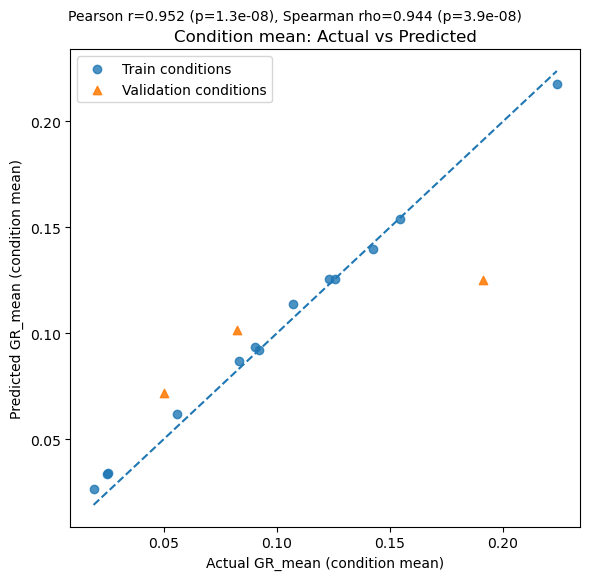

In [6]:
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, GradientNormClipping
import matplotlib.pyplot as plt

# 1) Build final pipe from best trial (same function you already use)
final_pipe = build_pipe_from_trial_decline(study.best_trial)

# 2) Make a single internal validation split (k random non-anchor conditions)
full_train_idx = np.arange(N)
inner_train_idx, inner_valid_idx, valid_groups = make_random_group_valid(
    full_train_idx, k=3, rng=123  # k=3 gives ~15 valid reps; tweak if you like
)
X_train_full, y_train_full = X[inner_train_idx], y[inner_train_idx]
# (Optional but recommended) augment labels only on the train partition
K_AUG = 200
X_train_aug, y_train_aug = augment_labels_normal(
    X_train_full, y_train_full, K=K_AUG, rng=202, min_gr=0.0, truncated=True
)

# 3) Attach predefined validation + callbacks (ReduceLROnPlateau + EarlyStopping)
if inner_valid_idx.size > 0:
    X_valid, y_valid = X[inner_valid_idx], y[inner_valid_idx]
    valid_ds = Dataset(X_valid.astype(np.float32, copy=False),
                       y_valid.astype(np.float32, copy=False))
    final_pipe.set_params(
        net__train_split=predefined_split(valid_ds),
        net__callbacks=[
            LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss',
                        factor=0.5, patience=5, min_lr=1e-6, cooldown=0),
            GradientNormClipping(1.0),
            EarlyStopping(patience=50, monitor='valid_loss', load_best=True),
        ],
        net__criterion__min_var=1e-4,
        # net__batch_size=128,   # switch off full-batch since we augmented
        net__verbose=1,
    )
else:
    final_pipe.set_params(net__train_split=None, net__callbacks=[], net__verbose=0)

# 4) Fit final model on ALL training samples (augmented)
set_seed(42)
final_pipe.fit(X_train_aug, y_train_aug)

# 5) Predict GR_mean for every replicate, then aggregate by condition
y_pred_all = final_pipe.predict(X).ravel()
y_true_all = y[:, 0].ravel()

cond_df = pd.DataFrame({
    'cond': cond_keys,
    'y_true': y_true_all,
    'y_pred': y_pred_all,
})
cond_means = cond_df.groupby('cond', as_index=False).mean(numeric_only=True)

# 6) Plot: actual condition mean vs predicted condition mean
mask_valid = cond_means['cond'].isin(valid_groups)  # True for groups used as validation
plt.figure(figsize=(6,6))
# train (used to fit)
plt.scatter(
    cond_means.loc[~mask_valid, 'y_true'],
    cond_means.loc[~mask_valid, 'y_pred'],
    alpha=0.8,
    label='Train conditions'
)
# validation (held out for ES)
plt.scatter(
    cond_means.loc[mask_valid, 'y_true'],
    cond_means.loc[mask_valid, 'y_pred'],
    alpha=0.9,
    marker='^',
    label='Validation conditions'
)

mn = float(min(cond_means['y_true'].min(), cond_means['y_pred'].min()))
mx = float(max(cond_means['y_true'].max(), cond_means['y_pred'].max()))
plt.plot([mn, mx], [mn, mx], linestyle='--')  # y = x reference
plt.xlabel('Actual GR_mean (condition mean)')
plt.ylabel('Predicted GR_mean (condition mean)')
plt.title('Condition mean: Actual vs Predicted')
plt.legend(loc='best')

# Optional: annotate with Pearson & Spearman on condition means
from scipy.stats import pearsonr, spearmanr
r, rp = pearsonr(cond_means['y_true'], cond_means['y_pred'])
rho, rhop = spearmanr(cond_means['y_true'], cond_means['y_pred'])
plt.suptitle(f"Pearson r={r:.3f} (p={rp:.2g}), Spearman rho={rho:.3f} (p={rhop:.2g})", y=0.96, fontsize=10)
plt.tight_layout()
plt.show()


In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager as fm

arial_path = "data/arial.ttf"
arial_font = fm.FontProperties(fname=arial_path)

# Force everything to use your font
rcParams['font.family'] = arial_font.get_name()
fm.fontManager.addfont(arial_path)   # register this font globally

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

mpl.rcParams.update({
    'font.family': 'Arial',
    'axes.linewidth': 2.0,
    'lines.linewidth': 2.0,
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.labelsize': 11,   # x-tick font size
    'ytick.labelsize': 11,   # keep y consistent
})

def _journal_axes(ax):
    # Only left & bottom axes visible, thicker spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(width=2.0, length=6)

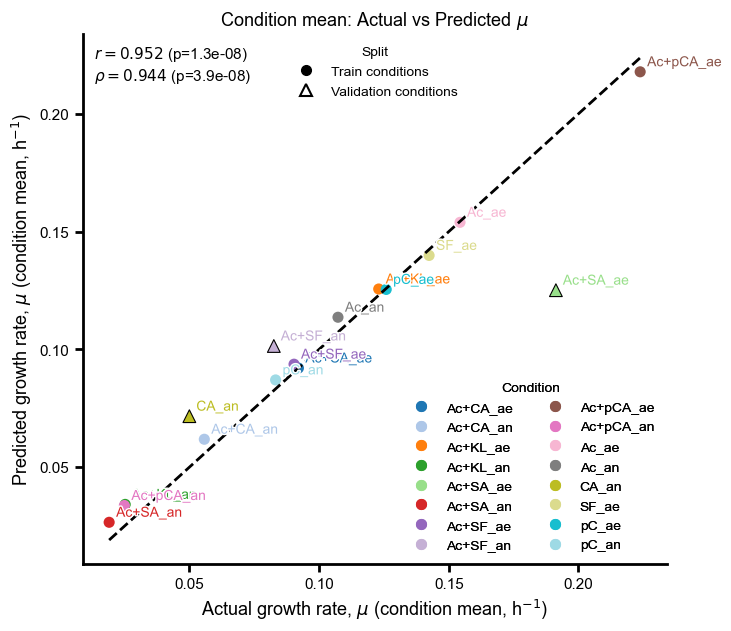

In [15]:
# ================= Condition-mean plot =================
unique_conds = sorted(cond_means['cond'].unique())
# Colorblind-friendly, publication-safe palette with enough distinct colors
cmap = plt.get_cmap('tab20', len(unique_conds))
cond_color = {c: cmap(i) for i, c in enumerate(unique_conds)}

mask_valid = cond_means['cond'].isin(valid_groups)  # validation conditions

fig, ax = plt.subplots(figsize=(7.2, 6.2), constrained_layout=True)

# Train conditions (circles)
sc_train = ax.scatter(
    cond_means.loc[~mask_valid, 'y_true'],
    cond_means.loc[~mask_valid, 'y_pred'],
    c=cond_means.loc[~mask_valid, 'cond'].map(cond_color),
    # alpha=0.95, s=64, marker='o', edgecolor='none'
    s=64, marker='o', edgecolor='none'
)

# Validation conditions (triangles)
sc_valid = ax.scatter(
    cond_means.loc[mask_valid, 'y_true'],
    cond_means.loc[mask_valid, 'y_pred'],
    c=cond_means.loc[mask_valid, 'cond'].map(cond_color),
    # alpha=0.95, s=84, marker='^', edgecolor='k', linewidths=0.8
    s=84, marker='^', edgecolor='k', linewidths=0.8
)

# Annotate each condition mean with its condition key (outlined for readability)
for _, row in cond_means.iterrows():
    x, ypt = float(row['y_true']), float(row['y_pred'])
    ckey = row['cond']
    txt = ax.annotate(
        ckey, (x, ypt),
        textcoords="offset points", xytext=(5, 4),
        fontsize=10, color=cond_color[ckey]
    )
    txt.set_path_effects([pe.withStroke(linewidth=2.0, foreground='white')])

# y = x reference line
mn = float(min(cond_means['y_true'].min(), cond_means['y_pred'].min()))
mx = float(max(cond_means['y_true'].max(), cond_means['y_pred'].max()))
ax.plot([mn, mx], [mn, mx], linestyle='--', color='black', linewidth=2.0)

# Labels / title
ax.set_xlabel(r'Actual growth rate, $\mu$ (condition mean, h$^{-1}$)', fontsize=13)
ax.set_ylabel(r'Predicted growth rate, $\mu$ (condition mean, h$^{-1}$)', fontsize=13)
ax.set_title(r'Condition mean: Actual vs Predicted $\mu$', fontsize=13)


# Legends: split (markers) + condition colors (outside right)
split_handles = [
    mpl.lines.Line2D([0], [0], marker='o', color='k', linestyle='None',
                     markersize=7, label='Train conditions', markerfacecolor='k'),
    mpl.lines.Line2D([0], [0], marker='^', color='k', linestyle='None',
                     markersize=8, label='Validation conditions', markerfacecolor='w', markeredgewidth=1.5)
]
# leg_split = ax.legend(handles=split_handles, title='Split', frameon=False, loc='lower right')
leg_split = ax.legend(handles=split_handles, title='Split', frameon=False, loc='upper center')
ax.add_artist(leg_split)

cond_handles = [
    mpl.lines.Line2D([0], [0], marker='o', linestyle='None', color=cond_color[c],
                     label=c, markersize=7)
    for c in unique_conds
]
leg_cond = ax.legend(handles=cond_handles, title='Condition', frameon=False, loc='lower right', ncol = 2,
                    #  bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0.
                     )
ax.add_artist(leg_cond)

# Stats annotation (use mathtext for Greek)
from scipy.stats import pearsonr, spearmanr
r, rp = pearsonr(cond_means['y_true'], cond_means['y_pred'])
rho, rhop = spearmanr(cond_means['y_true'], cond_means['y_pred'])
ax.text(0.02, 0.98,
        rf"$r={r:.3f}$ (p={rp:.2g})" + "\n" + rf"$\rho={rho:.3f}$ (p={rhop:.2g})",
        transform=ax.transAxes, va='top', ha='left', fontsize=11,
        bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.9, lw=0.0))

_journal_axes(ax)
# fig.tight_layout()
plt.show()


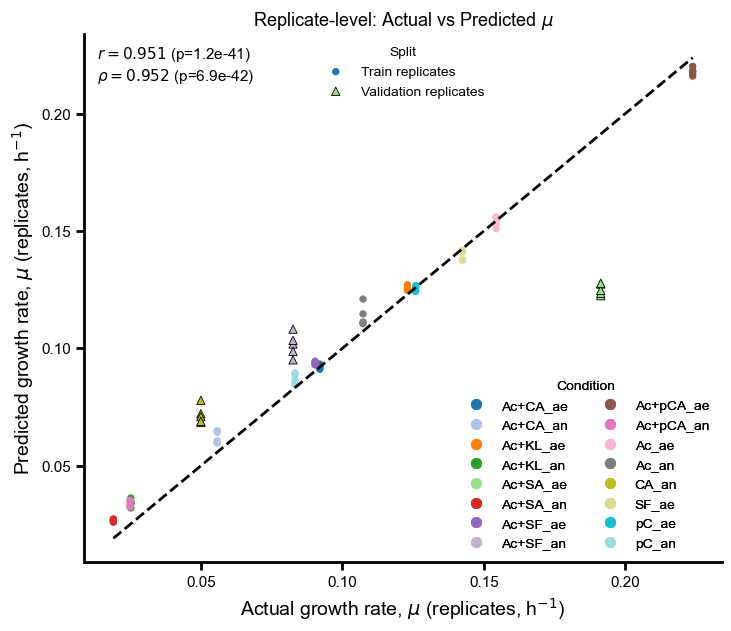

In [16]:

# ================= Replicate-level plot =================
rep_df = cond_df.copy()
rep_df['is_valid'] = rep_df['cond'].isin(valid_groups)
rep_df['color'] = rep_df['cond'].map(cond_color)

fig, ax = plt.subplots(figsize=(7.2, 6.2), constrained_layout=True)

# Train replicates (circles)
ax.scatter(
    rep_df.loc[~rep_df['is_valid'], 'y_true'],
    rep_df.loc[~rep_df['is_valid'], 'y_pred'],
    c=rep_df.loc[~rep_df['is_valid'], 'color'],
    # alpha=0.70, s=28, marker='o', edgecolor='none', label='Train replicates'
    s=28, marker='o', edgecolor='none', label='Train replicates'
)

# Validation replicates (triangles)
ax.scatter(
    rep_df.loc[rep_df['is_valid'], 'y_true'],
    rep_df.loc[rep_df['is_valid'], 'y_pred'],
    c=rep_df.loc[rep_df['is_valid'], 'color'],
    # alpha=0.85, s=36, marker='^', edgecolor='k', linewidths=0.6, label='Validation replicates'
    s=36, marker='^', edgecolor='k', linewidths=0.6, label='Validation replicates'
)

mn = float(min(rep_df['y_true'].min(), rep_df['y_pred'].min()))
mx = float(max(rep_df['y_true'].max(), rep_df['y_pred'].max()))
ax.plot([mn, mx], [mn, mx], linestyle='--', color='black', linewidth=2.0)

ax.set_xlabel(r'Actual growth rate, $\mu$ (replicates, h$^{-1}$)', fontsize=14)
ax.set_ylabel(r'Predicted growth rate, $\mu$ (replicates, h$^{-1}$)', fontsize=14)
ax.set_title(r'Replicate-level: Actual vs Predicted $\mu$', fontsize=13)


# Legends
# leg_split2 = ax.legend(title='Split', frameon=False, loc='lower right')
leg_split2 = ax.legend(title='Split', frameon=False, loc='upper center')

ax.add_artist(leg_split2)

# Optional compact condition legend (same as above, outside right)
leg_cond2 = ax.legend(handles=cond_handles, title='Condition', frameon=False, loc='lower right', ncol = 2,
                    #   bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0.
                      )
ax.add_artist(leg_cond2)

# Stats
r_rep, rp_rep = pearsonr(rep_df['y_true'], rep_df['y_pred'])
rho_rep, rhop_rep = spearmanr(rep_df['y_true'], rep_df['y_pred'])
ax.text(0.02, 0.98,
        rf"$r={r_rep:.3f}$ (p={rp_rep:.2g})" + "\n" + rf"$\rho={rho_rep:.3f}$ (p={rhop_rep:.2g})",
        transform=ax.transAxes, va='top', ha='left', fontsize=11,
        bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.9, lw=0.0))

_journal_axes(ax)
# fig.tight_layout()
plt.show()


# Load the Optuna search and get best Trial

In [ ]:
import optuna

STUDY_NAME = "rp_mu_pred_flexmlp"
STORAGE_URL = "sqlite:///results/data/optuna_studies_Proteomics.db"

study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
print("Best value:", study.best_value)
print("Best trial:", study.best_trial)          # full object
print("Best params:", study.best_trial.params)  # dict of hyperparams
